In [1]:
!pip install mplfinance

## 1. Import all using library

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import mplfinance as mpf
import yfinance as yf
import matplotlib.pyplot as plt
import talib
import keras
from sklearn.preprocessing import MinMaxScaler 
from sklearn import metrics

## 2. Data Preprocessing

In [3]:
data = yf.download('AAPL', start='2018-01-01', end='2023-01-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
df = data.copy()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.888069,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.880939,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.070831,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.538445,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.384148,82271200


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.658981,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.831772,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.847855,85438400
2022-12-29,127.989998,130.479996,127.730003,129.610001,129.412415,75703700
2022-12-30,128.410004,129.949997,127.430000,129.929993,129.731918,77034200


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


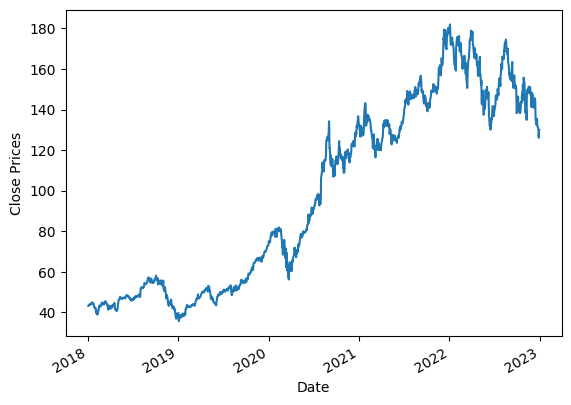

In [7]:
df['Close'].plot()
plt.ylabel("Close Prices")
plt.show()

In [8]:
close_prices = df['Close']
values = close_prices.values
train_len = np.ceil(len(values) * 0.6).astype(int)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: train_len, :]

x_train = []
y_train = []

for i in range(30, len(train_data)):
    x_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [9]:
test_data = scaled_data[train_len-30: , : ]
x_test = []
y_test = values[train_len:]

for i in range(30, len(test_data)):
  x_test.append(test_data[i-30:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [10]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(100, return_sequences=False))
model.add(keras.layers.Dense(20))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 123,241
Trainable params: 123,241
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=2)

Epoch 1/2
726/726 [==============================] - 16s 13ms/step - loss: 0.0017
Epoch 2/2
726/726 [==============================] - 8s 11ms/step - loss: 8.2190e-04


In [12]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 4.317784212692595
Mean Squared Error: 29.043653979042553
Root Mean Squared Error: 5.3892164531629785


C:\Users\USER\AppData\Local\Temp\ipykernel_29284\3179312626.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = y_pred


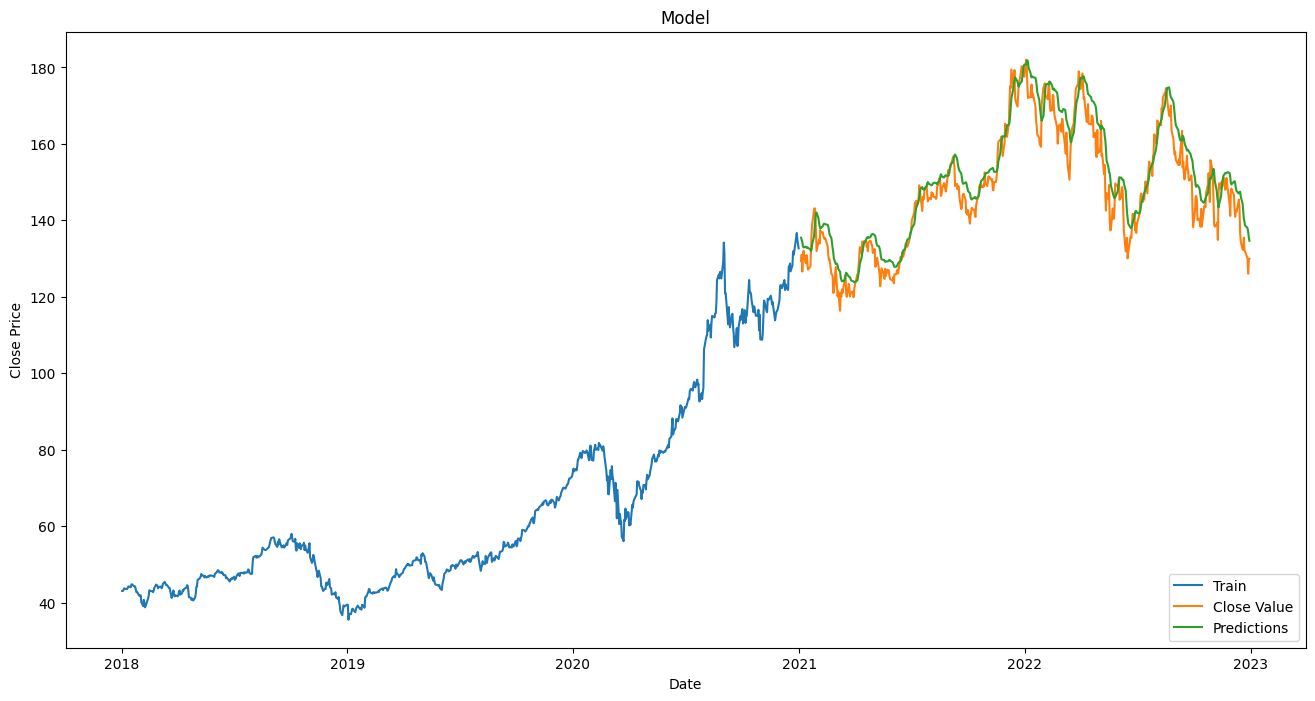

In [13]:
data = df.filter(['Close'])
train = data[:train_len]
validation = data[train_len:]
validation['Predictions'] = y_pred
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Close Value', 'Predictions'], loc='lower right')
plt.show()